## Conditional probability of aerial survey

Are surveys more likely in a year following mortality? Let $X_{i,j}$ denote a mortality observation for a pixel $i$ at time $j$. We are interested in whether

$$
\frac{P(X_{i,j+1} = \mathrm{nan}|X_{i,j}=0)}{P(X_{i,j+1} = \mathrm{nan}|X_{i,j}>1)} \neq 1.
$$

The null hypothesis is that this ratio is 1, while the alternative hypothesis is that the ratio is greater than one (i.e. future surveys are more likely when a pixel is observed with mortality).

In [3]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

mort = xr.open_dataset("../mort_datasets/westmort.nc")["mortality"]
mort

<xarray.DataArray 'mortality' (time: 25, y: 652, x: 590)> Size: 38MB
[9617000 values with dtype=float32]
Coordinates:
  * x        (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y        (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * time     (time) int64 200B 1999 2000 2001 2002 2003 ... 2020 2021 2022 2023

Only consider pixels that are not entirely nan and that had some mixture of mortality and no-mortality observations. This doesn't matter as far as getting a test statistic but makes running permutation tests a lot faster.

In [4]:
valid_y, valid_x = np.where((mort.mean(dim="time") > 0).data)

y_selector = xr.DataArray(mort.y.data[valid_y], dims=["pixel"])
x_selector = xr.DataArray(mort.x.data[valid_x], dims=["pixel"])

mort_valid_px = mort.sel(x=x_selector, y=y_selector)

In [5]:
mort_valid_px

<xarray.DataArray 'mortality' (time: 25, pixel: 55450)> Size: 6MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  4.,  3., ...,  1.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32)
Coordinates:
    x        (pixel) float64 444kB -1.357e+07 -1.356e+07 ... -1.228e+07
    y        (pixel) float64 444kB 6.274e+06 6.274e+06 ... 3.682e+06 3.678e+06
  * time     (time) int64 200B 1999 2000 2001 2002 2003 ... 2020 2021 2022 2023
Dimensions without coordinates: pixel

Find all the indices that are one time step before a nan.

In [6]:
mort_nan_t, mort_nan_px = np.where(mort_valid_px.isel(time=slice(1, None)).isnull())
mort_before_nan_t = mort_nan_t - 1

Select those cells, and check the distribution of mort/non-mort relative to their global ratio.

In [7]:
mort_t_selector  = xr.DataArray(mort_valid_px.time.data[mort_before_nan_t], dims=["sample"])
mort_px_selector = xr.DataArray(mort_valid_px.pixel.data[mort_nan_px], dims=["sample"])

mort_before_nan = mort_valid_px.sel(time=mort_t_selector, pixel=mort_px_selector).clip(0, 1)

print("Distribution of entire dataset")
abs_values, abs_counts = np.unique(mort_valid_px.clip(0, 1), return_counts=True)
print(abs_values, abs_counts)
abs_p_nomort = abs_counts[0] / np.sum(abs_counts)
abs_p_mort   = abs_counts[1] / np.sum(abs_counts)

print("Distribution of pixels before nan")
cond_values, cond_counts = np.unique(mort_before_nan, return_counts=True)
print(cond_values, cond_counts)
cond_p_nomort = cond_counts[0] / np.sum(cond_counts)
cond_p_mort   = cond_counts[1] / np.sum(cond_counts)

print("Overall likelihood ratio")
r = abs_p_nomort * cond_p_mort / (abs_p_mort * cond_p_nomort)
print(r)

Distribution of entire dataset
[ 0.  1. nan] [953647 241161 191442]
Distribution of pixels before nan
[ 0.  1. nan] [67416 18559 91197]
Overall likelihood ratio
1.0886096046297282


Write as a function for permutation testing.

In [8]:
def get_likelihood_ratio(arr):
    arr_nan_t, arr_nan_px = np.where(arr.isel(time=slice(1, None)).isnull())
    arr_before_nan_t = arr_nan_t - 1

    t_selector  = xr.DataArray(arr.time.data[arr_before_nan_t], dims=["sample"])
    px_selector = xr.DataArray(arr.pixel.data[arr_nan_px], dims=["sample"])
    
    arr_before_nan = arr.sel(time=t_selector, pixel=px_selector).clip(0, 1)

    # This should only be pixels that can be before a nan, so exclude
    # the last time step.
    #print("Distribution of entire dataset")
    abs_values, abs_counts = np.unique(arr.isel(time=slice(None, -1)).clip(0, 1), return_counts=True)
    #print(abs_values, abs_counts)
    abs_p_nomort = abs_counts[0] / np.sum(abs_counts)
    abs_p_mort   = abs_counts[1] / np.sum(abs_counts)
    
    #print("Distribution of pixels before nan")
    cond_values, cond_counts = np.unique(arr_before_nan, return_counts=True)
    #print(cond_values, cond_counts)
    cond_p_nomort = cond_counts[0] / np.sum(cond_counts)
    cond_p_mort   = cond_counts[1] / np.sum(cond_counts)
    
    #print("Overall likelihood ratio")
    r = abs_p_nomort * cond_p_mort / (abs_p_mort * cond_p_nomort)
    #print(r)

    return r

In [9]:
# Should get same result with original array
test_stat = get_likelihood_ratio(mort_valid_px)
print(test_stat)

1.1078036767841866


In [10]:
# Now copy the array, shuffle it, and see what the ratio is.
# It should be one, since shuffling would remove any temporal
# autocorrelation in the data.
from tqdm.autonotebook import tqdm

def run_trial():
    mort_copy = mort_valid_px.data.copy().flatten()
    np.random.shuffle(mort_copy)
    mort_copy = mort_copy.reshape(mort_valid_px.shape)
    
    # Turn it back into a data array (although tbh just doing this
    # with numpy arrays might be easier.
    mort_copy_arr = xr.DataArray(
        mort_copy,
        dims=mort_valid_px.dims,
        coords=mort_valid_px.coords
    )
    return get_likelihood_ratio(mort_copy_arr)

n_trials = 500
ratios = np.zeros(n_trials)
for i in tqdm(range(n_trials)):
    ratios[i] = run_trial()

/tmp/ipykernel_134/1207342944.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/500 [00:00<?, ?it/s]

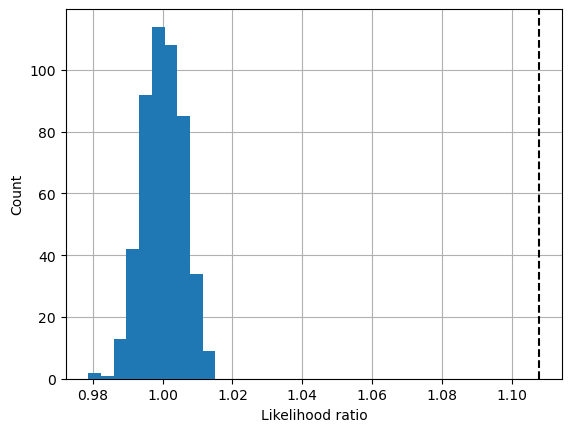

In [11]:
plt.xlabel("Likelihood ratio")
plt.ylabel("Count")
plt.grid(zorder=0)
plt.hist(ratios, zorder=3)
plt.axvline(test_stat, color="black", linestyle="--", zorder=3)
plt.show()

Conclusion: pixels with no mortality are ~10% more likely to not be surveyed the following year than pixels with mortality.